In [1]:
#!pip install tensorflow==2.11
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 12.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import tensorboard
import datetime
import sklearn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import shap

kaggle = False

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [3]:
# Random seed for reproducibility
seed = 54721

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
if not kaggle:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if kaggle:
  train_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/train'
  test_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/test'
  val_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/val'
else:
  %cd /content/drive/MyDrive/data_splitted_patient
  train_dir = 'train'
  test_dir = 'test'
  val_dir = 'val'
  
image_size = 400 # images are 400x400x3
batch_size = 16

/content/drive/.shortcut-targets-by-id/14D0QUtOpcrgcCk3Apj2azcVrgj1H9LqD/data_splitted_patient


In [6]:
class_names = ['N','P','T']
class_samples = [0] * len(class_names)

In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.0,
    # It doesn't matter here the shuffle -> set to False to have the heatmap
    shuffle=False,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 1991 files belonging to 3 classes.


In [8]:
class_names = test_ds.class_names
num_classes = len(class_names)
print("There are {} classes".format(num_classes))

There are 3 classes


In [9]:
# Add caching to dataset
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Use one-hot encoding for labels
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

In [11]:
# Load the model
if not kaggle:
  model = tfk.models.load_model("/content/drive/MyDrive/Models/EfficientnetModel")
  # model = tfk.models.load_model("/content/drive/MyDrive/Models/InceptionResnetModel")
  # model = tfk.models.load_model("/content/drive/MyDrive/Models/ScratchModel")

## Evaluating the model performances

In [12]:
# Compute the prediction on the test data
predictions = model.predict(test_ds)
y_predicted = tf.argmax(predictions, axis=-1)

125/125 [==============================] - 272s 2s/step


In [13]:
# Take all the true labels and save them in an array
y_true =  np.array([])
for x, y in test_ds:
  y_true = np.concatenate([y_true, np.argmax(y, axis=-1)])

print("There are {} images in the test set".format(y_true.shape[0]))

There are 1991 images in the test set


Accuracy: 0.9518
Precision: 0.9319
Recall: 0.9328
F1 score class N: 0.9621
F1 score class P: 0.9661
F1 score class T: 0.8689
F1: 0.9324


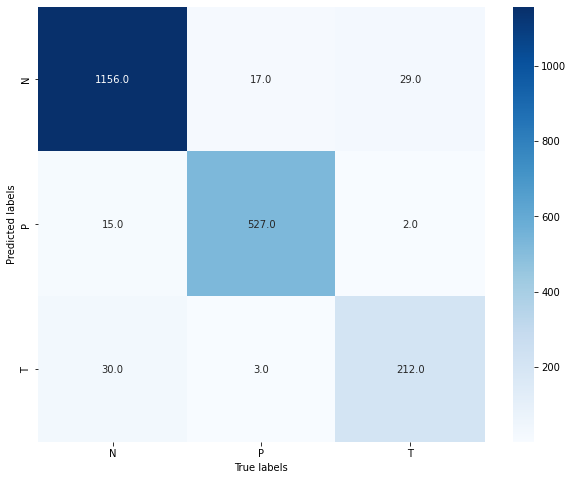

In [14]:
# Compute the confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_predicted)

# Define the labels
class_labels = np.array(["N", "P", "T"])

# Compute the classification metrics
accuracy = accuracy_score(y_true, y_predicted)
precision = precision_score(y_true, y_predicted, average='macro')
recall = recall_score(y_true, y_predicted, average='macro')
f1_for_class = f1_score(y_true, y_predicted, average=None)
f1 = f1_score(y_true, y_predicted, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))

for i in range(class_labels.shape[0]):
  print("F1 score class {}: {}".format(class_labels[i], f1_for_class[i].round(4)))

print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix.T, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
def confidence_evaluation(predictions, y_true, confidence=0.33):
  """
  This method receives the predictions(probabilities) of the models and 
    it computes the evaluation metrics using only the prediction
    where the max probabilities is above a confidence threshold.
  """
  # List that will contain only the prediction with a certain confidence
  confident_predictions = []
  # List that will contain the true labels corresponding to the selected predictions
  confident_y_true = []

  # Count how many predicions are not confident
  count_non_confident = 0

  for i, prediction in enumerate(predictions):
    # If the max probability > confidence
    if np.max(prediction, axis=-1) > confidence:
      confident_predictions.append(prediction)
      confident_y_true.append(y_true[i])
    else:
      # Increase the counter
      count_non_confident += 1

  # Conver the list into an array
  confident_predictions = np.array(confident_predictions)
  # Get the predicted classes
  confident_y_predicted = np.argmax(confident_predictions, axis=-1)

  print("The number of discarded predictions is {}({:.2f}%)".format(count_non_confident, count_non_confident*100/predictions.shape[0]))

  # Compute the classification metrics
  accuracy = accuracy_score(confident_y_true, confident_y_predicted)
  precision = precision_score(confident_y_true, confident_y_predicted, average='macro')
  recall = recall_score(confident_y_true, confident_y_predicted, average='macro')
  f1 = f1_score(confident_y_true, confident_y_predicted, average='macro')
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  print('F1:',f1.round(4))


In [16]:
# Standard evaluation
confidence_evaluation(predictions, y_true, confidence=0.33)

The number of discarded predictions is 0(0.00%)
Accuracy: 0.9518
Precision: 0.9319
Recall: 0.9328
F1: 0.9324


In [17]:
# Evaluation with a confidence of 0.5 
confidence_evaluation(predictions, y_true, confidence=0.5)

The number of discarded predictions is 6(0.30%)
Accuracy: 0.9537
Precision: 0.9356
Recall: 0.9346
F1: 0.9351


In [18]:
# Evaluation with a confidence of 0.8
confidence_evaluation(predictions, y_true, confidence=0.8)

The number of discarded predictions is 179(8.99%)
Accuracy: 0.9796
Precision: 0.9789
Recall: 0.9663
F1: 0.9724


In [19]:
def print_probabilities(image, predictions, class_names, true_label, ax1=None):
  # Plot the target images and the predictions

  if ax1 is not None:
    ax1.barh(class_names, predictions.squeeze(), color=plt.get_cmap('Paired').colors)
    ax1.set_title('Predicted label: '+class_names[np.argmax(predictions)])
    ax1.grid(alpha=.3)
    return

  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(10,4)

  ax1.imshow(image)
  ax1.set_title('True label: '+ true_label)

  ax2.barh(class_names, predictions.squeeze(), color=plt.get_cmap('Paired').colors)
  ax2.set_title('Predicted label: '+class_names[np.argmax(predictions)])
  ax2.grid(alpha=.3)

  plt.show()

In [20]:
def rotate_image(image, degree=90):
  """
  This method rotate the input image of 0,90,180 or 270 degrees
  """

  if degree == 90:
    rotateCode = cv2.ROTATE_90_CLOCKWISE
  elif degree == 180:
    rotateCode = cv2.ROTATE_180
  elif degree == 270 or degree == (-90):
    rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
  else:
    print("Wrong degree")
    return image

  # Rotate the image
  rotated_image = cv2.rotate(image, rotateCode)
  return rotated_image

# Model Explainability
## GradCam

In [21]:
def GradCam(model, img_array, layer_name, eps=1e-8, class_value=0):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = tfk.Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32) #we use the preprocessed image
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, class_value]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0,1)) # axis=(0, 1)
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8") # Maybe comment this part
		# return the resulting heatmap to the calling function
    return heatmap,predictions

In [22]:
def sigmoid(x, a, b, c):
  return c / (1 + np.exp(-a * (x-b)))

def display_gradcam(img, heatmap, ax=None):
    # Load the original image
    #img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

    #heatmap = sigmoid(heatmap, 50, thresh, 1)

    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    if ax is None:
      plt.imshow(superimposed_img)
    else:
      ax.imshow(superimposed_img)

In [23]:
def display_triplets(images, grad_cams, predictions, class_names, true_labels):
  # Create a row for each image
  fig, axes = plt.subplots(len(images), 4, figsize=(15,12 * len(images) // 3))

  for i in range(len(images)):
    # Display the original image
    axes[i,0].imshow(images[i])
    axes[i,0].set_title('True label: '+ true_labels[i])
    # Display the heatmap
    axes[i,1].imshow(grad_cams[i])
    axes[i,1].set_title('Heatmap')
    # Display the effect on the real image
    display_gradcam(images[i], grad_cams[i], ax=axes[i,2])
    axes[i,2].set_title('GradCAM')
    # Display the prediction results
    print_probabilities(image=images[i], predictions=predictions[i], 
                        class_names=class_names, true_label=true_labels[i], 
                        ax1=axes[i,3])

  plt.show()

In [24]:
# Get the name of all the images in the test set for classes T and P
T_images_paths = os.listdir('test/T')
P_images_paths = os.listdir('test/P')
len(T_images_paths), len(P_images_paths)

(243, 547)

In [41]:
# Choose a number of images to show for each group
num_of_images_per_group = 3

# Get random images
random_T_images = np.random.choice(T_images_paths, num_of_images_per_group)
random_T_images = ['test/T/' + path for path in random_T_images]
random_P_images = np.random.choice(P_images_paths, num_of_images_per_group)
random_P_images = ['test/P/' + path for path in random_P_images]

# Concatenate them to get a unique list
images_path = np.concatenate((random_T_images, random_P_images))

images_path = list(np.concatenate((random_T_images, random_P_images)))
# Create the list with the labels
images_label = ['T'] * len(random_T_images) + ['p'] * len(random_P_images)

images = []
grad_cams = []
predictions_list = []

# Analyze the convolutional part
base_model = model.get_layer("efficientnetv2-b2")
# Select a layer to analyze
layer_name = 'block6j_expand_conv' 

# Case of inception model
# base_model = model.get_layer("inception_resnet_v2")
# layer_name = 'conv2d_71'
# layer_name = 'conv2d_143'

image_size = 400
cropping = 50

# Case pf scratch model
# base_model = model
# layer_name = 'conv2d_7'
# cropping = 0

for path in images_path:
  image = cv2.imread(path)
  # Resize the image if necessary
  image = cv2.resize(image, dsize=(image_size, image_size))
  # Append the image to the list
  images.append(image)
  # Get the grad cam of the image
  grad_cam,_ = GradCam(base_model, np.expand_dims(image[:, cropping:image_size-cropping, : ], axis=0), layer_name) 
  grad_cams.append(grad_cam)
  # Compute the prediction
  predictions_list.append(model.predict(np.expand_dims(image, axis=0)))

1/1 [==============================] - 0s 31ms/step


GradCam wrt class N


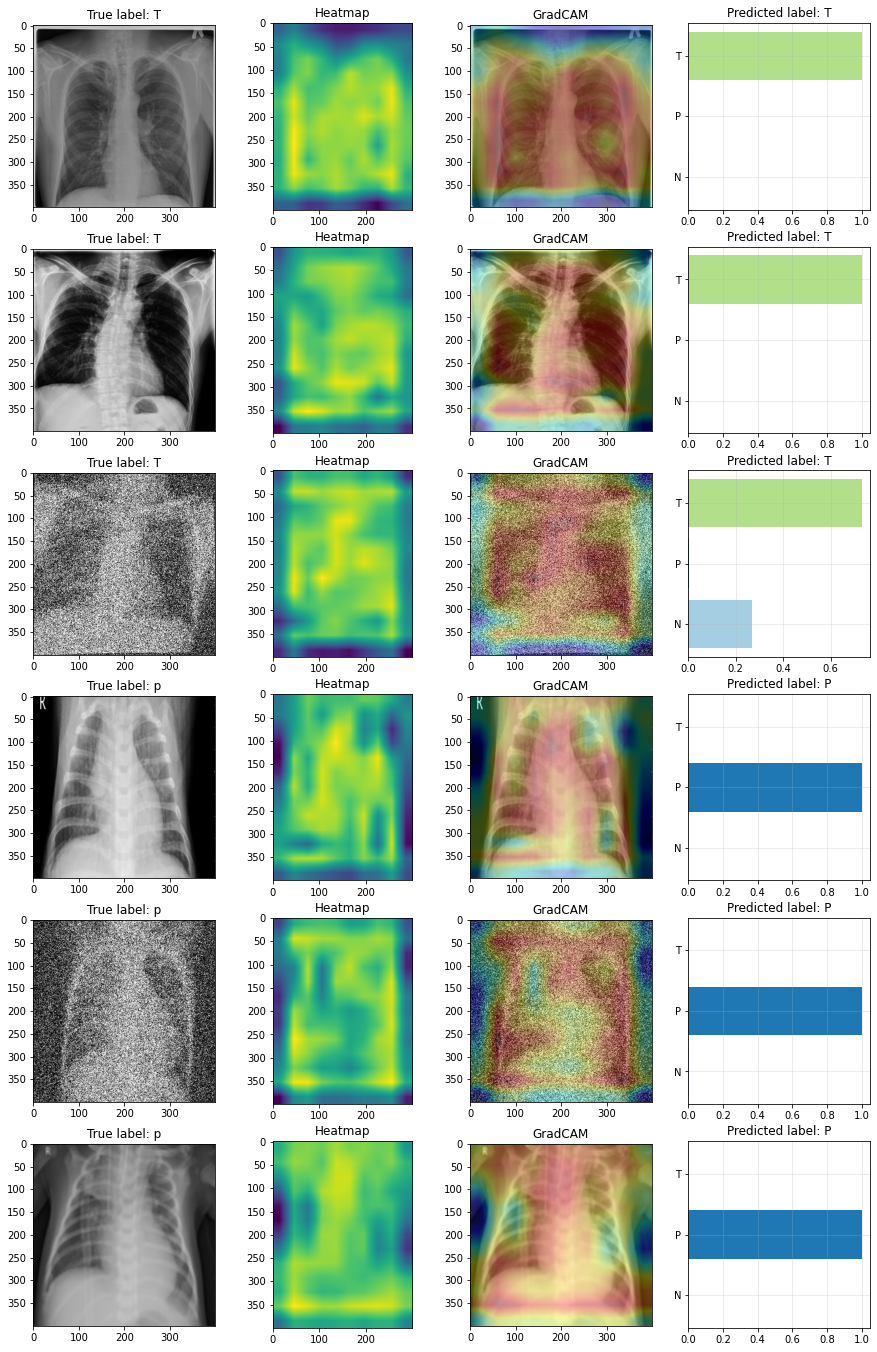

In [42]:
print("GradCam wrt class N")
display_triplets(images=images, grad_cams=grad_cams, predictions=predictions_list, true_labels=images_label, class_names=class_names)

In [43]:
images = []
grad_cams = []
predictions_list = []

# Analyze the convolutional part
base_model = model.get_layer("efficientnetv2-b2")
# Select a layer to analyze
layer_name = 'block6j_expand_conv' 

# Case of inception model
# base_model = model.get_layer("inception_resnet_v2")
# layer_name = 'conv2d_71'
# layer_name = 'conv2d_143'

image_size = 400
cropping = 50

# Case pf scratch model
# base_model = model
# layer_name = 'conv2d_7'
# cropping = 0

for path in images_path:
  image = cv2.imread(path)
  # Resize the image if necessary
  image = cv2.resize(image, dsize=(image_size, image_size))
  # Append the image to the list
  images.append(image)
  # Get the grad cam of the image
  grad_cam,_ = GradCam(base_model, np.expand_dims(image[:, cropping:image_size-cropping, : ], axis=0), layer_name, class_value=1) 
  grad_cams.append(grad_cam)
  # Compute the prediction
  predictions_list.append(model.predict(np.expand_dims(image, axis=0)))

1/1 [==============================] - 0s 54ms/step


GradCam wrt class P


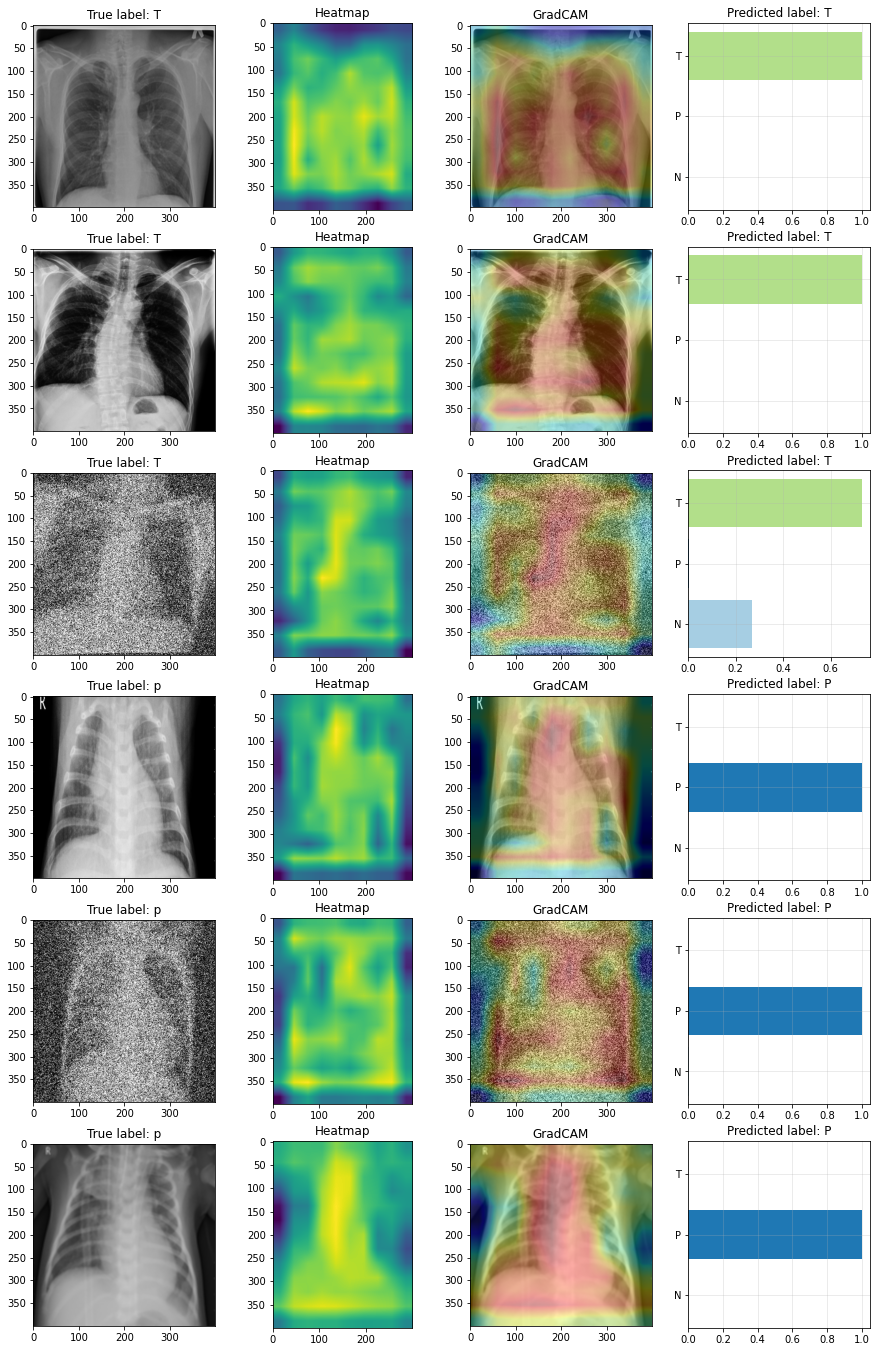

In [44]:
print("GradCam wrt class P")
display_triplets(images=images, grad_cams=grad_cams, predictions=predictions_list, true_labels=images_label, class_names=class_names)

In [45]:
images = []
grad_cams = []
predictions_list = []

# Analyze the convolutional part
base_model = model.get_layer("efficientnetv2-b2")
# Select a layer to analyze
layer_name = 'block6j_expand_conv' 

# Case of inception model
# base_model = model.get_layer("inception_resnet_v2")
# layer_name = 'conv2d_71'
# layer_name = 'conv2d_143'

image_size = 400
cropping = 50

# Case pf scratch model
# base_model = model
# layer_name = 'conv2d_7'
# cropping = 0

for path in images_path:
  image = cv2.imread(path)
  # Resize the image if necessary
  image = cv2.resize(image, dsize=(image_size, image_size))
  # Append the image to the list
  images.append(image)
  # Get the grad cam of the image
  grad_cam,_ = GradCam(base_model, np.expand_dims(image[:, cropping:image_size-cropping, : ], axis=0), layer_name, class_value=2) 
  grad_cams.append(grad_cam)
  # Compute the prediction
  predictions_list.append(model.predict(np.expand_dims(image, axis=0)))

1/1 [==============================] - 0s 34ms/step


GradCam wrt class T


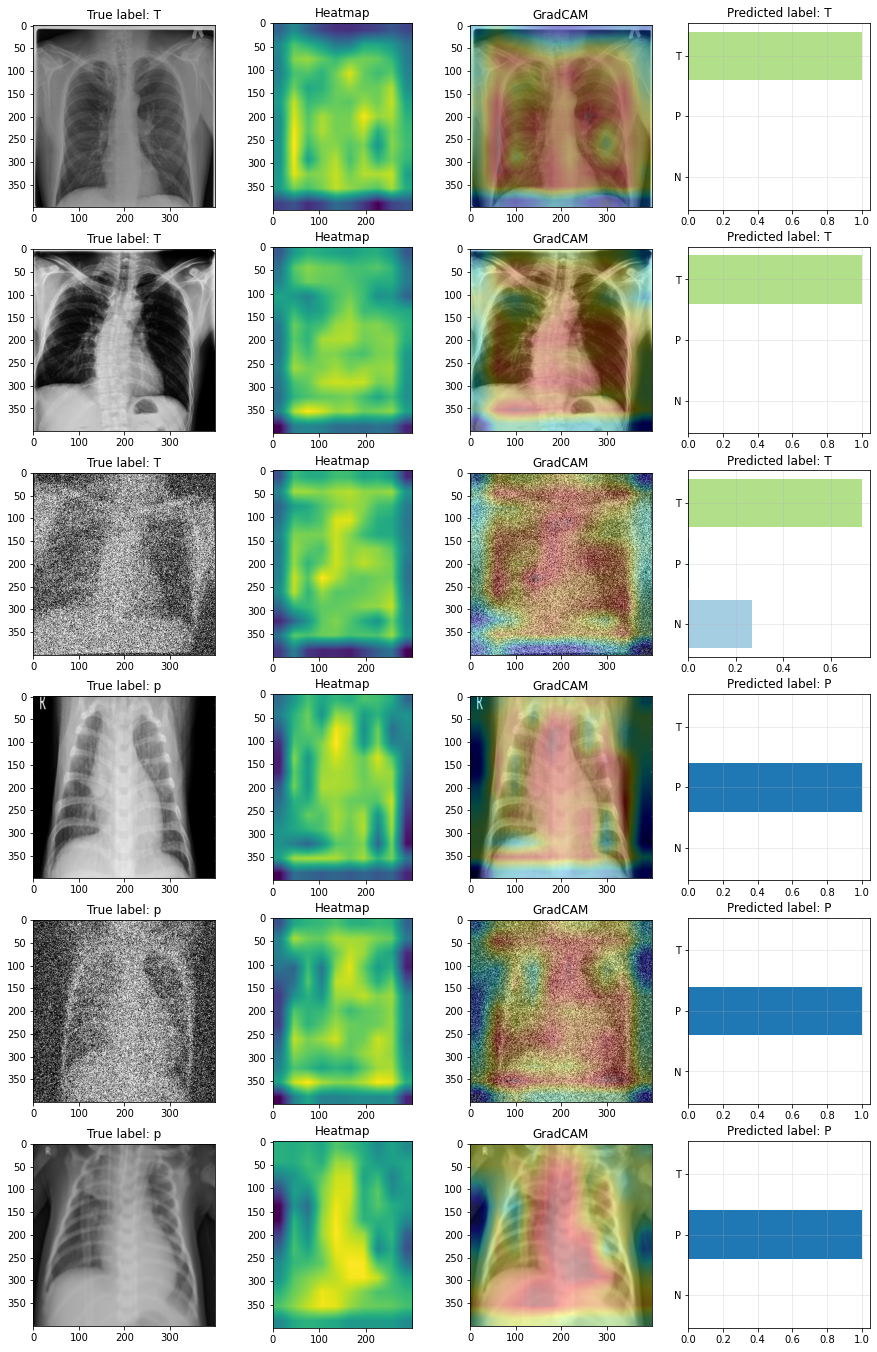

In [46]:
print("GradCam wrt class T")
display_triplets(images=images, grad_cams=grad_cams, predictions=predictions_list, true_labels=images_label, class_names=class_names)

In [40]:
# Select the degree of the rotation
# The results with a degree of 180 are still consistent and that's okay
# The cases with a different degrees lead to wrong predictions but that's okay,
#   we assume these rotatations cannot happen
degree = 180
# Change the list of images in rotated images
rotated_images = [rotate_image(image, degree) for image in images]

In [32]:
rotated_grad_cams = []
rotated_predictions_list = []

for image in rotated_images:
  # Get the grad cam of the image
  rotated_grad_cam,_=GradCam(base_model, np.expand_dims(image[:, cropping:image_size-cropping, : ], axis=0), layer_name) 
  rotated_grad_cams.append(rotated_grad_cam)
  # Compute the prediction
  rotated_predictions_list.append(model.predict(np.expand_dims(image, axis=0)))

1/1 [==============================] - 0s 30ms/step


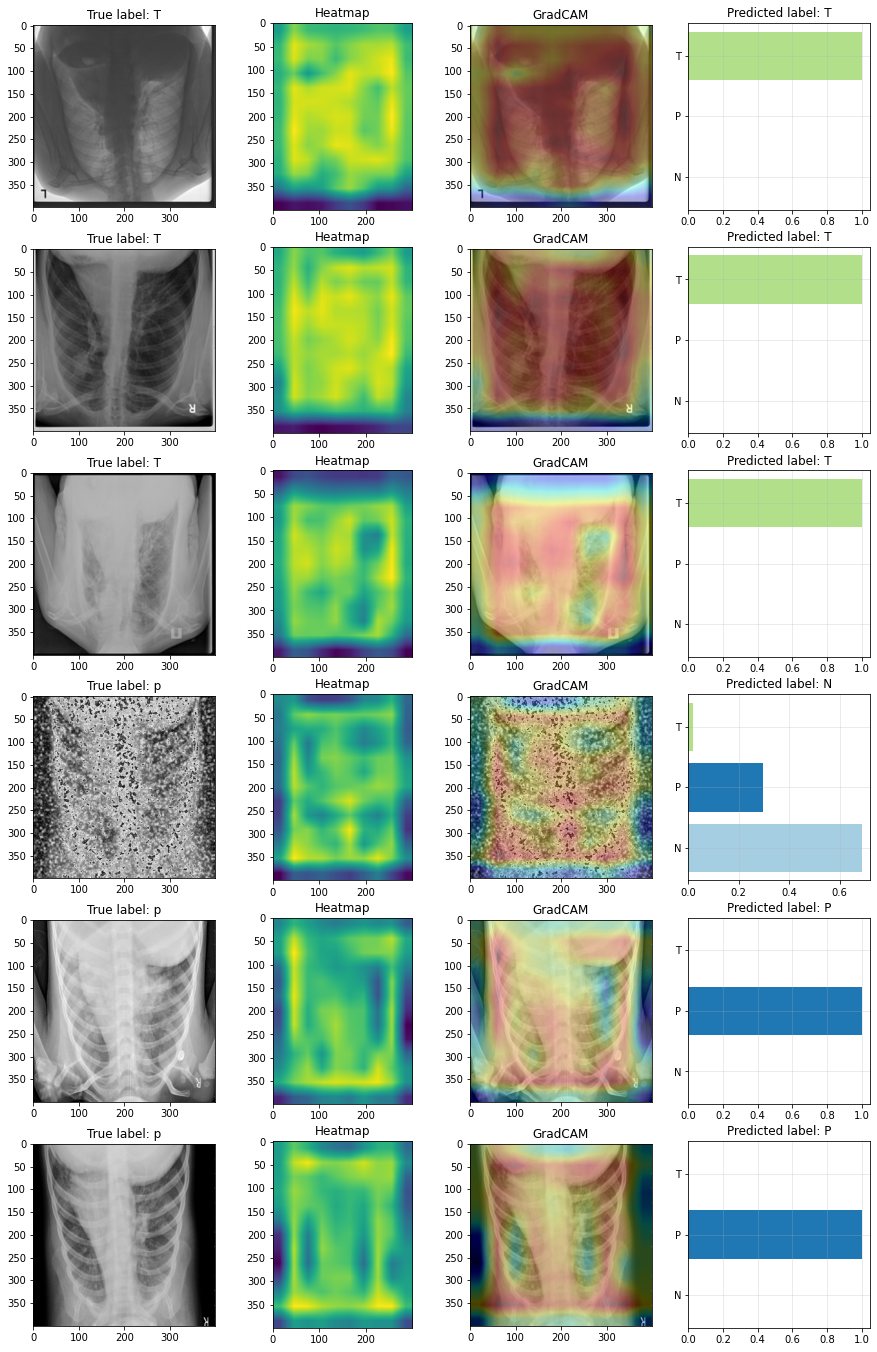

In [33]:
display_triplets(images=rotated_images, grad_cams=rotated_grad_cams, predictions=rotated_predictions_list, true_labels=images_label, class_names=class_names)

# Explainability
## Shap

In [ ]:
print("SHAP Version : {}".format(shap.__version__))

SHAP Version : 0.41.0


In [ ]:
# The alternative is "inpain_ns"
masker = shap.maskers.Image("inpaint_telea", (400, 400, 3))
explainer = shap.Explainer(model, masker, output_names=class_names)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:08, 68.60s/it]               


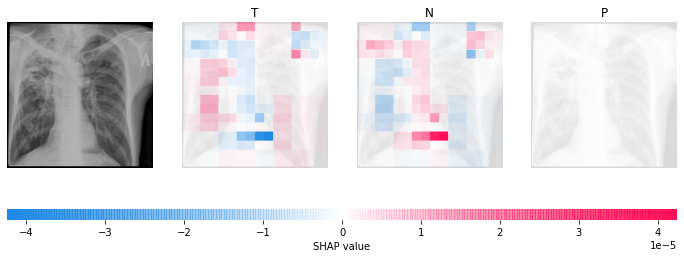

In [ ]:
# Get one image
img = images[1]

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(np.expand_dims(img, axis=0), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])
shap.image_plot(shap_values)

# Red parts  -> positive contribute
# Blue parts -> negative contribute 

In [ ]:
# Convert the list into an array
images_array = np.array(images)

In [ ]:
# Define a masker that is used to mask out partitions of the input image, 
#     this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", images_array[0].shape)
explainer = shap.Explainer(model, masker, output_names=class_names)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:08, 68.02s/it]               


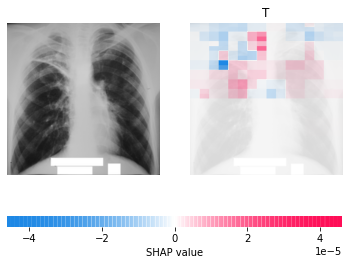

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:08, 68.05s/it]               


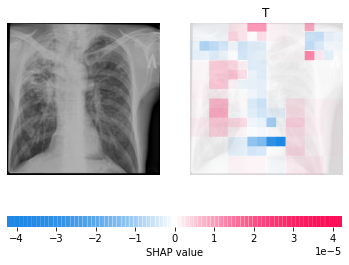

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:06, 66.47s/it]               


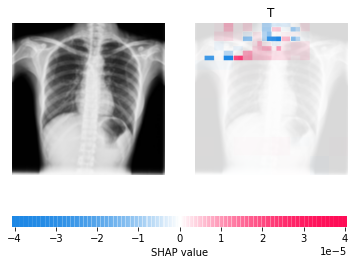

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:51, 51.38s/it]               


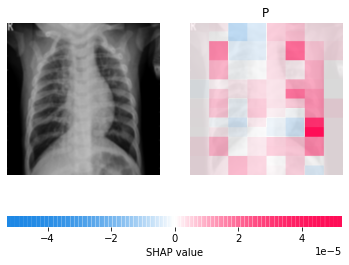

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:53, 53.97s/it]               


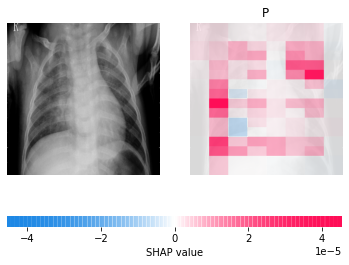

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:02, 62.78s/it]               


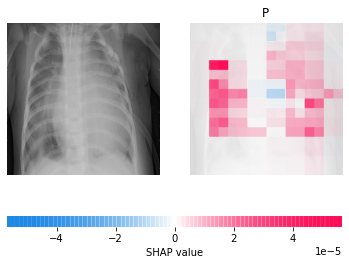

In [ ]:
# Red parts  -> positive contribute
# Blue parts -> negative contribute 

for i,image in enumerate(images_array):
  # Here we use 500 evaluations of the underlying model to estimate the SHAP values
  shap_values = explainer(np.expand_dims(image, axis=0), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
  shap.image_plot(shap_values,  width=60)
  # print_probabilities(image, model.predict(np.expand_dims(image, axis=0)), class_names, images_label[i])